# ZDoom Physics
Apparently the Doom physics engine is complicated and not entirely known. This notebook will try to empirically derive some features, such as linear and angular acceleration, that are needed to compute Q-values analytically.

## Initial setup

In [1]:
from vizdoom import *
import sys
sys.path.insert(0, "../python")
import tensorflow as tf
import numpy as np
import math
from time import time
import copy
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def initialize_vizdoom(config_file):
    print("Initializing doom... ")
    game = DoomGame()
    game.load_config(config_file)
    game.init()
    return game  

## Angular acceleration

In [78]:
config_file = "../notebooks/zdoom_physics/basic.cfg"
game = initialize_vizdoom(config_file)
game.new_episode()

steps = 100
cycles = 2
theta = []
for i in range(3):
    for j in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([1, 0, 0]) # turn left

    for j in range(steps // 2, steps, 1):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([0, 1, 0]) # turn right

# Now stop to come to a rest and start again.
for i in range(steps // 2, steps, 1):
    theta.append(game.get_game_variable(GameVariable.ANGLE))
    game.make_action([0, 0, 0])

for i in range(3):
    for j in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([0, 1, 0]) # turn right

    for j in range(steps // 2, steps, 1):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([1, 0, 0]) # turn left
        
# Now stop to come to a rest and start again.
for i in range(steps // 2, steps, 1):
    theta.append(game.get_game_variable(GameVariable.ANGLE))
    game.make_action([0, 0, 0])

for i in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        if i % 2 == 0:
            game.make_action([0, 1, 0]) # turn right
        else:
            game.make_action([1, 0, 0]) # turn left
        
theta = np.asarray(theta)

print("Finished.")
game.close()

Initializing doom... 
Finished.


min_velocity: -3.516
max_velocity: 3.516
min_acceleration: -7.031
max_acceleration: 7.031


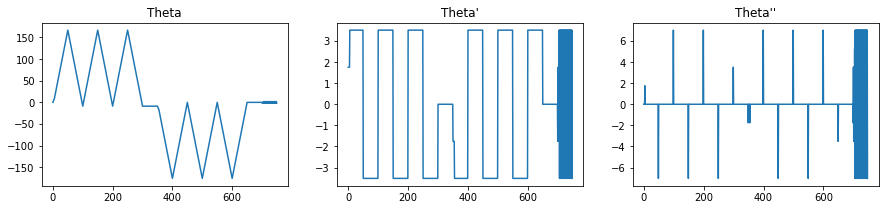

In [79]:
# Calcultate first derivative
dtheta_dt = (np.roll(theta, -1) - theta)[:-1]

# Exclude jumps at boundaries (e.g. 0 --> 359)
jumps = np.squeeze(np.argwhere(abs(dtheta_dt) > 100) + 1)
for i in range(jumps.size // 2):
    theta[jumps[2*i]:jumps[2*i+1]] -= 360
if jumps.size % 2 == 1:
    theta[jumps[-1]:] -= 360
    
# Calculate first and second derivatives
dtheta_dt = (np.roll(theta, -1) - theta)[:-1]
d2theta_dt2 = (np.roll(dtheta_dt, -1) - dtheta_dt)[:-1]

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot theta vs. time
_ = ax[0].plot(theta)
_ = ax[0].set_title("Theta")

# Plot theta' vs. time
_ = ax[1].plot(dtheta_dt)
_ = ax[1].set_title("Theta'")

# Plot theta'' vs. time
_ = ax[2].plot(d2theta_dt2)
_ = ax[2].set_title("Theta''")

print("min_velocity: %.3f" % np.min(dtheta_dt))
print("max_velocity: %.3f" % np.max(dtheta_dt))
print("min_acceleration: %.3f" % np.min(d2theta_dt2))
print("max_acceleration: %.3f" % np.max(d2theta_dt2))

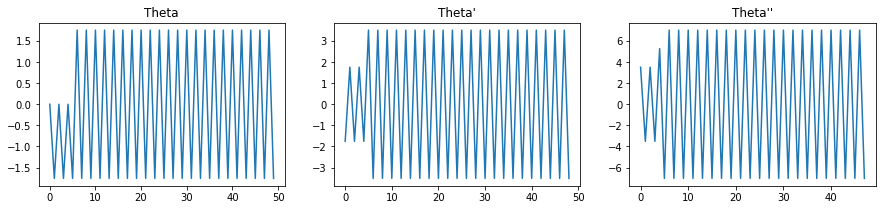

In [80]:
# Blow up last part
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot theta vs. time
_ = ax[0].plot(theta[700:])
_ = ax[0].set_title("Theta")

# Plot theta' vs. time
_ = ax[1].plot(dtheta_dt[700:])
_ = ax[1].set_title("Theta'")

# Plot theta'' vs. time
_ = ax[2].plot(d2theta_dt2[700:])
_ = ax[2].set_title("Theta''")

It appears that when starting with no angular momentum, the angular speed increases to 1.75 for two tics, then to its max of 3.52 for the remainder of the turn. Once the agent has gained angular momentum of any form, however, turning results in an angular speed of 3.52 in either direction. Because the acceleration to max angular speed is so fast, it is safe to assume that turning generally results in an angular speed of 3.52.

## Linear acceleration

In [ ]:
config_file = "../notebooks/zdoom_physics/basic.cfg"
game = initialize_vizdoom(config_file)
game.new_episode()

steps = 100
cycles = 2
theta = []
for i in range(3):
    for j in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([1, 0, 0]) # turn left

    for j in range(steps // 2, steps, 1):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([0, 1, 0]) # turn right

# Now stop to come to a rest and start again.
for i in range(steps // 2, steps, 1):
    theta.append(game.get_game_variable(GameVariable.ANGLE))
    game.make_action([0, 0, 0])

for i in range(3):
    for j in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([0, 1, 0]) # turn right

    for j in range(steps // 2, steps, 1):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        game.make_action([1, 0, 0]) # turn left
        
# Now stop to come to a rest and start again.
for i in range(steps // 2, steps, 1):
    theta.append(game.get_game_variable(GameVariable.ANGLE))
    game.make_action([0, 0, 0])

for i in range(steps // 2):
        theta.append(game.get_game_variable(GameVariable.ANGLE))
        if i % 2 == 0:
            game.make_action([0, 1, 0]) # turn right
        else:
            game.make_action([1, 0, 0]) # turn left
        
theta = np.asarray(theta)

print("Finished.")
game.close()